In [20]:
import torch
import argparse
from resnet_model import resnet
from config_args_gp import get_args
import util_tool.evaluate as evaluate
import util_tool.logger as logger
from optim_schedule import WarmupLinearSchedule
from run_epoch_gp import run_epoch, run_epoch_test
import yaml
#personality
from dataset import load_dataset
from gp_layer import DirichletClassificationLikelihood
from gp_layer import ResnetExtractor, DirichletGPModel
import gpytorch
import botorch
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from resnet_model import resnet_model
import torchvision

# load the dataset

In [21]:
args = get_args(argparse.ArgumentParser())
device = "cpu"
args.device = device
class_labels = ["alexander_mcqueen", "donatella_versace", "john_galliano", "karl_lagerfeld", "yves_saint_laurent"]

train_loader, val_loader, test_loader = load_dataset(args)
print('Labels: {}'.format(args.num_classes))

print(args.device)

Labels: 5
cpu


# load the resnet model

In [22]:
def load_saved_model(saved_model_name,model,likelihood):
    checkpoint = torch.load(saved_model_name,map_location='cuda:0')
    likelihood.load_state_dict(checkpoint['likelihood_state_dict'])
    model.load_state_dict(checkpoint['state_dict'])
    return model, likelihood

In [23]:
resnet_extractor = resnet_model(args.num_classes,backbone="resnet18")
resnet_extractor = resnet_extractor.to(args.device)
checkpoint = torch.load(args.saved_backbone_name, map_location=device)
resnet_extractor.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# Freeze the backbone

In [24]:
if args.freeze_backbone:
    for name, p in resnet_extractor.named_parameters():
#         print(name)
        p.requires_grad = False

# get the embeddings from backbone

In [25]:
train_embeddings = []
train_classes = []
for i, (image, target) in enumerate(train_loader):
    # if i>20:
    #     break
    print("{}/{}".format(i,int(len(train_loader.dataset)/args.batch_size)+1))
    image = image.to(args.device)
    target = target.to(args.device)
    train_embeddings.append(resnet_extractor(image)) #n*5
#     train_embeddings.append(resnet_extractor.backbone(image)) #n*512
    train_classes.append(target)

train_embeddings = torch.cat(train_embeddings,dim=0)
train_classes = torch.cat(train_classes,dim=0)

test_embeddings = []
test_classes = []
n_test = len(test_loader.dataset)
for i, (image, target) in enumerate(test_loader):
    print("{}/{}".format(i,int(len(test_loader.dataset)/args.batch_size)+1))
    image = image.to(args.device)
    target = target.to(args.device)
    test_embeddings.append(resnet_extractor(image))
#     test_embeddings.append(resnet_extractor.backbone(image))
    test_classes.append(target)
test_embeddings = torch.cat(test_embeddings,dim=0)
test_classes = torch.cat(test_classes,dim=0)

0/60
1/60
2/60
3/60
4/60
5/60
6/60
7/60
8/60
9/60
10/60
11/60
12/60
13/60
14/60
15/60
16/60
17/60
18/60
19/60
20/60
21/60
22/60
23/60
24/60
25/60
26/60
27/60
28/60
29/60
30/60
31/60
32/60
33/60
34/60
35/60
36/60
37/60
38/60
39/60
40/60
41/60
42/60
43/60
44/60
45/60
46/60
47/60
48/60
49/60
50/60
51/60
52/60
53/60
54/60
55/60
56/60
57/60
58/60
59/60
0/17
1/17
2/17
3/17
4/17
5/17
6/17
7/17
8/17
9/17
10/17
11/17
12/17
13/17
14/17
15/17
16/17


# define likelihood and GP

In [26]:
likelihood = gpytorch.likelihoods.DirichletClassificationLikelihood(train_classes.to(torch.int64), learn_additional_noise=True)
model = DirichletGPModel(train_embeddings, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)
model = model.to(device)
likelihood = likelihood.to(device)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
mll.train()

ExactMarginalLogLikelihood(
  (likelihood): DirichletClassificationLikelihood(
    (noise_covar): FixedGaussianNoise()
    (second_noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): DirichletGPModel(
    (likelihood): DirichletClassificationLikelihood(
      (noise_covar): FixedGaussianNoise()
      (second_noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
    (scaler): ScaleToBounds()
    (fc): Linear(in_features=5, out_features=2, bias=True)
  )
)

## optimize GP

In [28]:
print("training GP")
optimization_trace = []
botorch.optim.fit.fit_gpytorch_mll_torch(mll, step_limit=1000, optimizer=lambda p: torch.optim.Adam(p, lr=0.01), callback=lambda _,i: optimization_trace.append(i))
print("finished")

training GP
finished


## visualization

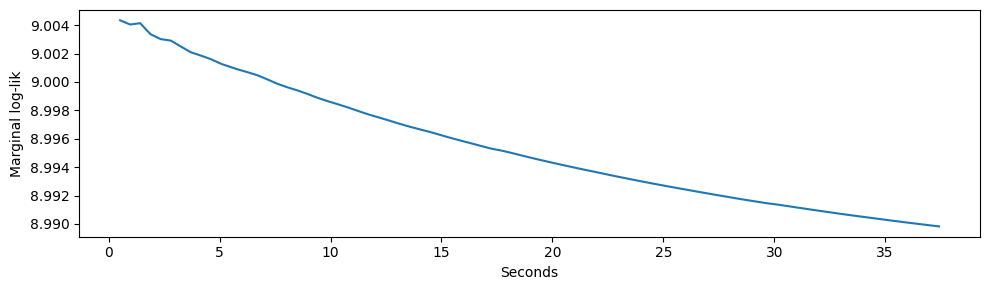

OptimizationStatus.STOPPED `torch_minimize` stopped due to `stopping_criterion`.


In [31]:
f,ax = plt.subplots(1,1,tight_layout=True,figsize=(10,3))
ax.plot([r.runtime for r in optimization_trace], [r.fval for r in optimization_trace])
ax.set_ylabel('Marginal log-lik');ax.set_xlabel('Seconds');
plt.show(f);plt.close(f)
print(optimization_trace[-1].status, optimization_trace[-1].message)

## testing

In [32]:
model.eval()
likelihood.eval()
with torch.no_grad():
    test_pred_dist = model(test_embeddings)
test_pred_samples = test_pred_dist.sample(torch.Size((256,))).exp()
print(test_pred_samples.shape)
test_probabilities = (test_pred_samples / test_pred_samples.sum(1, keepdim=True)).mean(0)
print(test_probabilities.shape)

test_classes = test_classes.detach().cpu()
test_probabilities = test_probabilities.detach().cpu()
pred_classes = torch.argmax(test_probabilities,dim=0,keepdim=False)
print(pred_classes.shape)

torch.Size([256, 5, 541])
torch.Size([5, 541])
torch.Size([541])


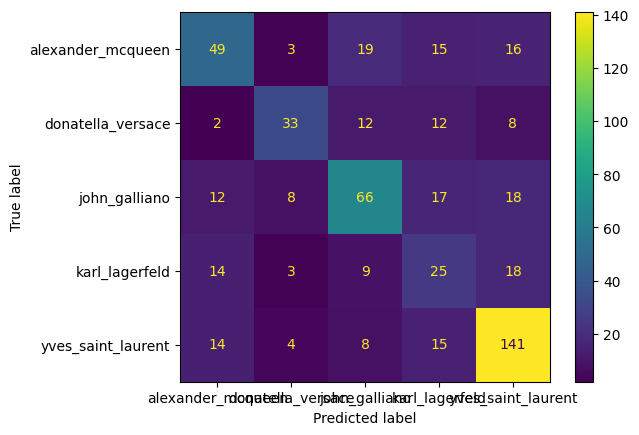

In [33]:
sklearn.metrics.ConfusionMatrixDisplay(
    sklearn.metrics.confusion_matrix(test_classes, (pred_classes)),
    display_labels=class_labels
).plot();

In [34]:

print('ROC-AUC',np.round(sklearn.metrics.roc_auc_score(
    test_classes,
    torch.softmax(test_probabilities,dim=0).t(),multi_class='ovr'
),2))

print('Acc',np.round(sklearn.metrics.accuracy_score(
    test_classes,
    (torch.argmax(test_probabilities,dim=0,keepdim=False))
)*100,2),'%')

# print(test_probabilities.t().shape)
# pred = test_probabilities.t().argmax(-1)
# correct = pred.eq(test_classes).cpu().sum()
# acc = 100. * correct / float(len(test_loader.dataset))
# print(acc)


ROC-AUC 0.79
Acc 58.04 %


## visualize the results

In [35]:
from functools import cache

tensor_to_image = torchvision.transforms.ToPILImage()
@cache
def tensor_to_url(tensor, size=128):
    return fr"data:image/png;base64,{base64.b64encode(PIL.ImageOps.contain(tensor_to_image(tensor), (size, size))._repr_png_()).decode('ascii')}"

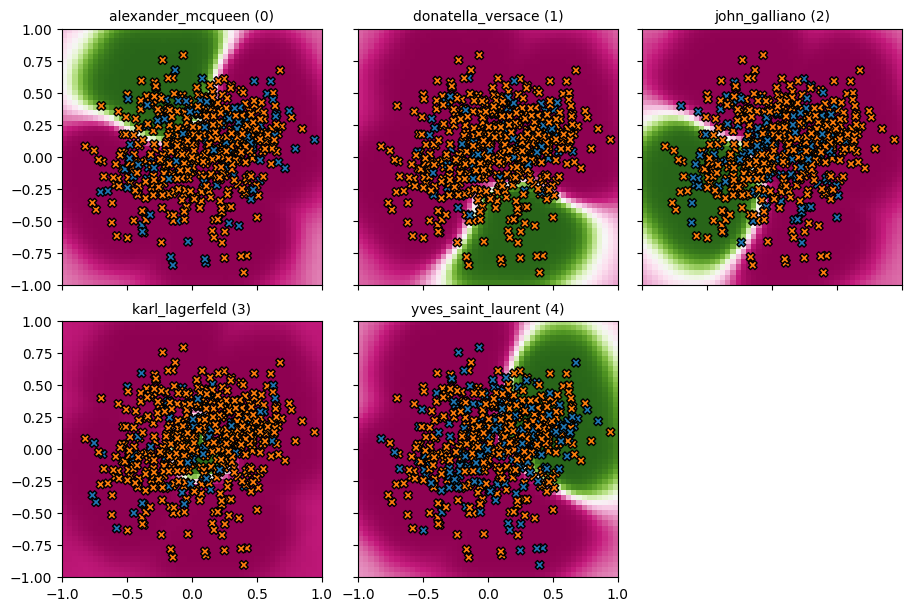

In [41]:
x_grid = torch.as_tensor(np.stack(np.meshgrid(np.linspace(-1,1), np.linspace(-1,1)), -1)).to(model.train_inputs[0])
y_grid = model.embedding_posterior(x_grid.view(-1,2))

y_grid = y_grid.sample(torch.Size((256,))).exp()
y_grid_mean = (y_grid / y_grid.sum(1, keepdim=True)).mean(0)

all_classes = sorted(train_classes.unique().numpy())
n_cols = 3
n_rows = int(np.ceil(len(all_classes)/n_cols))
f,axs = plt.subplots(
    n_rows,n_cols, figsize=(n_cols*3, n_rows*3),
    sharex=True, sharey=True, constrained_layout=True
)
for ax in axs.flat:
    ax.set_visible(False)
for i in range(len(all_classes)):
    ax = axs.flat[i]
    ax.set_visible(True)
    ax.set_title(f'{class_labels[i]} ({i})', fontsize=10)
    ax.imshow(
        y_grid_mean[i].view(x_grid.shape[:2]).numpy(force=True), cmap='PiYG',
        origin='lower', aspect='auto', extent=[-1,1,-1,1],
        vmin=0, vmax=1
    )
#     ax.scatter(
#         *model.transform((train_embeddings)).numpy(force=True).T,
#         c=(train_classes != i),
#         vmin=0, vmax=10, marker='o', cmap='tab10', edgecolor='k',
#         s=20
#     )
    ax.scatter(
        *model.transform((test_embeddings)).numpy(force=True).T,
        c=(test_classes != i),
        vmin=0, vmax=10, marker='X', cmap='tab10', edgecolor='k',
        s=40
    )

In [37]:
import json
img_root = '/home/sicelukwanda/modm/datasets/fashion_designers_list/'

with open(img_root+"train.json", 'r') as json_file:
    train_metadata = json.load(json_file)
with open(img_root+"val.json", 'r') as json_file:
    val_metadata = json.load(json_file)
with open(img_root+"test.json", 'r') as json_file:
    test_metadata = json.load(json_file)

class_labels = ["alexander_mcqueen","donatella_versace","john_galliano","karl_lagerfeld","yves_saint_laurent"]
print(class_labels)

n_train = len(train_metadata)
n_test = len(test_metadata)
n_val = len(val_metadata)

train_classes = torch.empty(n_train, dtype=torch.int)
train_images = [None]*n_train
for i,meta in enumerate(train_metadata):
    train_classes[i] = meta['label']
    train_images[i] = torchvision.io.read_image(img_root+meta['file_path']).to(device)

test_classes = torch.empty(n_test, dtype=torch.int)
test_images = [None]*n_test
for i,meta in enumerate(test_metadata):
    test_classes[i] = meta['label']
    test_images[i] = torchvision.io.read_image(img_root+meta['file_path']).to(device)

val_classes = torch.empty(n_test, dtype=torch.int)
val_images = [None]*n_val
for i,meta in enumerate(val_metadata):
    test_classes[i] = meta['label']
    val_images[i] = torchvision.io.read_image(img_root+meta['file_path']).to(device)

# print(train_images[1])

['alexander_mcqueen', 'donatella_versace', 'john_galliano', 'karl_lagerfeld', 'yves_saint_laurent']


In [38]:
with torch.no_grad():
    kernel_test_train = model.covar_module(model.transform(test_embeddings), model.transform(train_embeddings)).evaluate().numpy()

In [39]:
%%html
<style>
    html {
        --small-size: 42px;
    }
    .small-box {
        width: calc(var(--small-size) - 4px); height: calc(var(--small-size) - 2px);
        border-top: 2px solid; border-left: 2px solid;
        //flex: 0 0 auto;
    }
    .small-holder {
        display: flex;
        flex-direction: column;
        flex-wrap: wrap;
        border: 2px solid;
        box-sizing: border-box;
        border-top: 0;
        border-left: 0;
        height: calc(var(--small-size) * 4);
        width: calc(var(--small-size)*2);
    }
    .small-holder > .small-box:nth-child(4n) {
        height: calc(var(--small-size) - 4px);
    }
    .big-box {
        width: calc(var(--small-size) * 4); height: calc(var(--small-size) * 4);
    }
    .img-box > img {
        //border-left: 1px dashed red;
        //border-right: 1px dashed red;
    }
    .border {
        border: 2px solid;
        box-sizing: border-box;
    }
    .img-box {}
    .img-box > img {
        display: block;
        margin: 0 auto;
        max-height: 100%;
        max-width: 100%;
    }
    *[data-class="0"] {
        border-left: 3px solid #1f77b4;
    }
    *[data-class="1"] {
        border-left: 3px solid #ff7f0e;
    }
    *[data-class="2"] {
        border-left: 3px solid #2ca02c;
    }
    *[data-class="3"] {
        border-left: 3px solid #d62728;
    }
        *[data-class="4"] {
        border-left: 3px solid #d62728;
    }
</style>


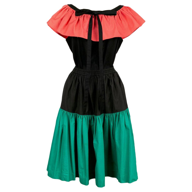
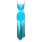
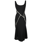
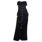
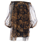
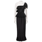
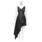
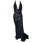
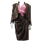
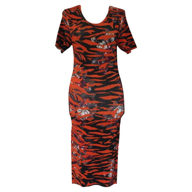
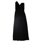
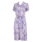
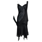
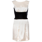
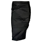
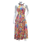
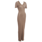
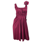
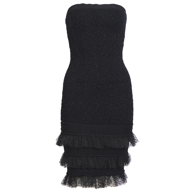
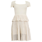
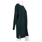
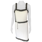
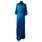
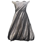
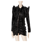
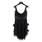
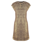
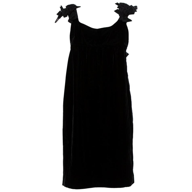
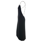
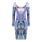
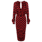
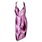
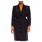
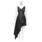
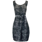
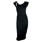
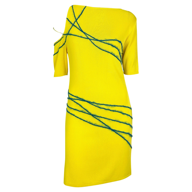
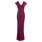
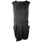
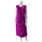
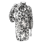
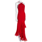
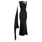
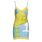
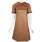
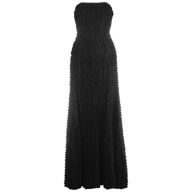
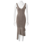
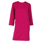
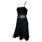
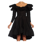
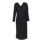
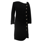
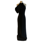
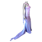
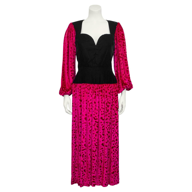
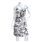
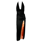
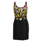
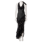
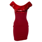
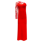
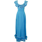
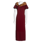
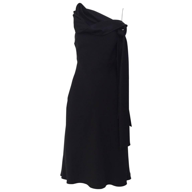
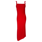
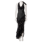
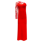
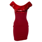
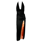
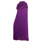
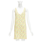
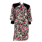
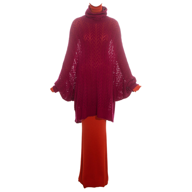
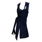
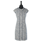
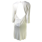
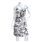
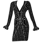
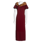
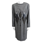
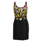
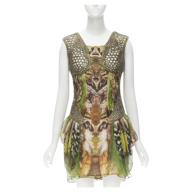
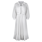
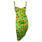
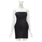
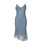
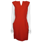
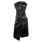
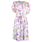
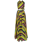
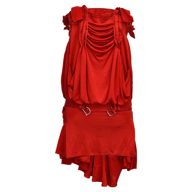
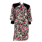
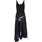
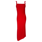
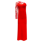
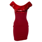
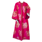
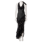
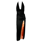
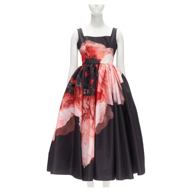
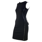
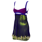
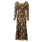
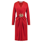
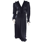
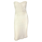
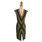
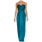
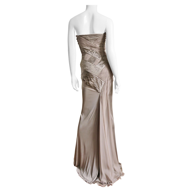
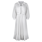
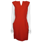
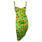
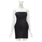
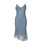
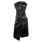
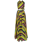
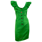
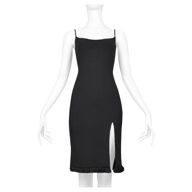
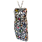
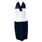
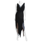
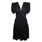
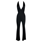
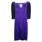
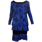
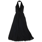
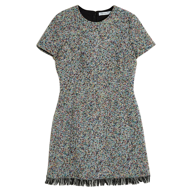
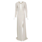
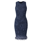
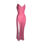
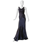
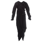
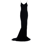
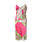
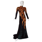
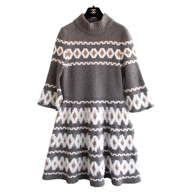
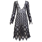
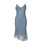
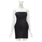
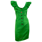
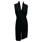
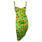
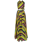
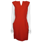
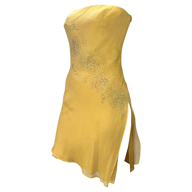
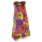
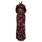
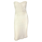
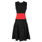
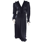
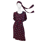
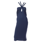
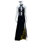
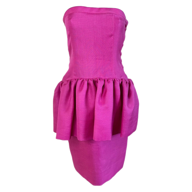
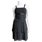
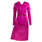
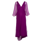
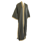
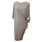
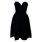
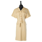
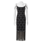
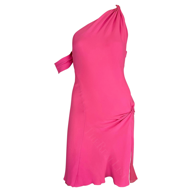
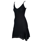
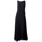
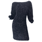
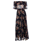
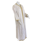
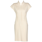
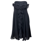
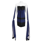
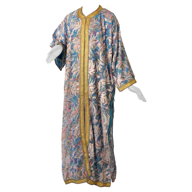
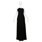
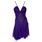
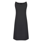
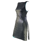
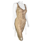
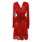
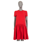
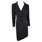
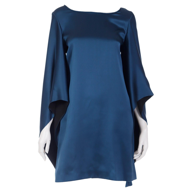
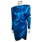
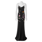
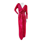
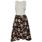
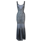
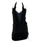
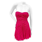
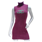
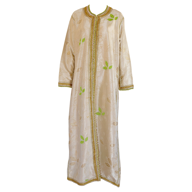
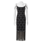
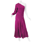
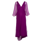
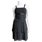
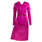
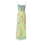
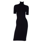
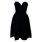
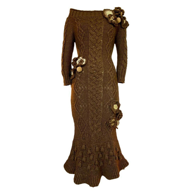
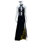
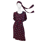
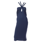
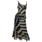
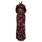
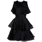
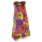
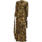
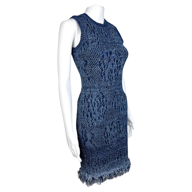
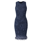
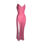
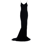
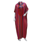
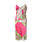
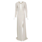
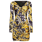
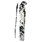
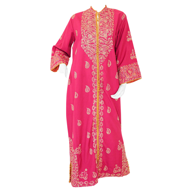
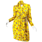
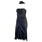
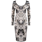
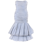
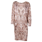
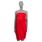
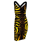
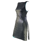
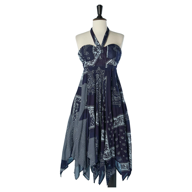
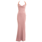
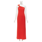
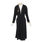
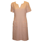
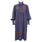
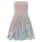
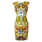
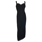
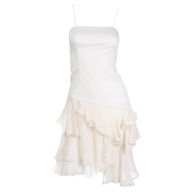
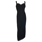
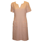
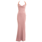
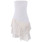
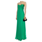
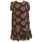
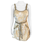
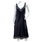
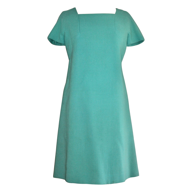
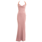
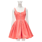
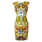
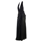
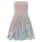
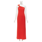
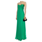
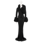
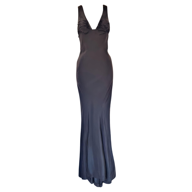
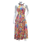
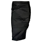
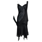
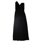
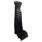
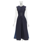
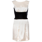
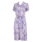
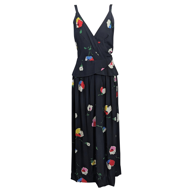
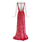
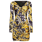
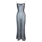
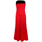
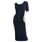
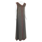
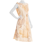
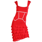

In [40]:
# Packages for Jupyter notebook
import IPython.display as ipd
import matplotlib.pyplot as plt
import PIL
import base64

html_str = "<div style='display: flex;gap: 22px;flex-wrap: wrap;'>"
for i in sorted(range(n_test), key=lambda i: test_probabilities[test_classes[i],i])[:30]:
    top_5 = np.argsort(kernel_test_train[0][i])[::-1][:8]
    top_5_figures = ''.join([
        fr"""<div class="img-box small-box" data-class="{train_classes[j]}"><img src="{tensor_to_url(train_images[j], 42)}"></div>"""
        for j in top_5
    ])
    html_str += fr'''<div>
    <div style='margin: 0 auto; display: flex;'>
    <div class="img-box big-box border" style='border-right: 0 !important;' data-class="{test_classes[i]}">
        <img src="{tensor_to_url(test_images[i], 192)}">
    </div>
    <div class="small-holder">{top_5_figures}</div>
    </div>
    <pre>
P(c={test_classes[i]}): {100*test_probabilities[test_classes[i],i].numpy(force=True):0.2f}%
Class:  {class_labels[test_classes[i]]}</pre> 
    </div>'''
html_str += '</div>'
ipd.HTML(html_str)